Initial world


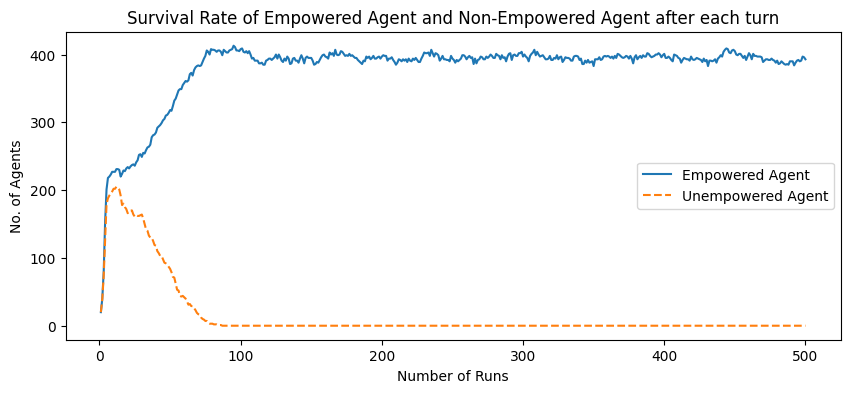

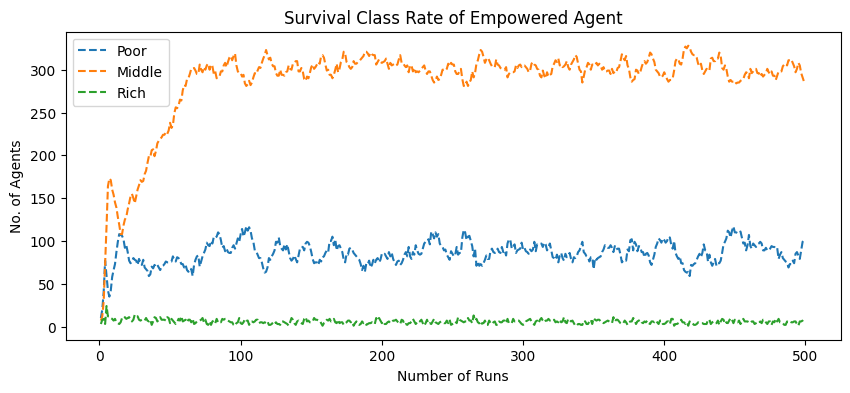

In [ ]:
from enum import Enum
import math
import random

##directional cardinal vectors
class Direction(Enum):
    NORTH = -1, 0 
    SOUTH = 1, 0
    EAST = 0, 1
    WEST = 0,-1

#defines the direction for reproduction
class BirthPlace(Enum):
    SOUTHEAST  = 1,1 
    NORTHWEST  = -1,-1 
    SOUTHWEST  = 1,-1 
    NORTHEAST = -1,1

#defining agent class
class Agent:
    def __init__(self,name):
        self.energy = 10
        self.sight = random.randint(2,5)
        self.name = name
        self.pos = None
        self.x, self.y = None, None
        self.vision = {}
        self.listVision = []
        
        self.detail = ""

    #define  movement for agent
    #makes agent to to loccation with highest sugar
    def move(self, location=None):
        loc = self.whereTo()
        if location:
            loc = location
        if loc and loc != self.pos:
            world.grid[self.pos[0]][self.pos[1]] = None
            world.grid[loc[0]][loc[1]] = self
            self.updateEnergy(loc)
            #self.vision = {}
            self.pos = loc
            self.x, self.y = loc[0], loc[1]
    
    #update agent energy after 
    #reducate sugar level in world
    def updateEnergy(self, loc):
        if loc in world.sugar:
            self.energy += world.sugar[loc]
            world.reduceSugar(loc)
        
        self.detail += f"Agent's Energy: {self.energy}\n"
        self.detail += f'sugar Level: {world.sugar[loc]}\n'

    #determines the next location agents wants to collect sugar
    def whereTo(self):
        self.computeVision()
        vision_sugar = {}

        for key in self.vision:
            if key in world.sugar and (self.isFree(key) or key == self.pos):
                vision_sugar[key] = world.sugar[key] 
        try:
            max_vision = max(vision_sugar, key=vision_sugar.get)
            max_visions = [key for key, value in vision_sugar.items() if value == vision_sugar[max_vision]]
            rand = random.randint(0, len(max_visions)-1)
            max_vision = max_visions[rand]

            self.detail += f'vision_sugar: {vision_sugar} - length: {len(vision_sugar)}\n'
            self.detail += f'next move: {max_vision}\n'
       
            return max_vision
        except ValueError:
            return None

    #Checks of a specified state is free 
    #@para: loc - state to be checked
    #return True is free, False otherwise
    def isFree(self, loc):
        if world.grid[loc[0]][loc[1]] == None:
            return True
        return False
    
    #compute vision search for states in the world
    def computeVision(self):
        self.vision = {}
        whereTo = self.pos
        self.vision[whereTo] = world.grid[whereTo[0]][whereTo[1]]
        self.listVision.append(world.grid[whereTo[0]][whereTo[1]])
        
        for direction in Direction:
            for i in range (self.sight):
                whereTo = tuple((x + y)%20 for x, y in zip(whereTo, direction.value))
                self.vision[whereTo] = world.grid[whereTo[0]][whereTo[1]]
                self.listVision.append(world.grid[whereTo[0]][whereTo[1]])
            whereTo = self.pos

    #reduces agent energy by 1
    #checks for fetility of agent
    #causes reproduction
    def metabolism(self):
        if self.energy > 0:
            self.energy -= 1
        
        #agent dies
        if not self.energy:
            world.grid[self.pos[0]][self.pos[1]] = None
            world.agents.remove(self)
        
        #check fertility of the agent
        if self.energy > 20:
            self.reproduce()
        
        if isinstance(self, EmpoweredAgent):
            self.updateHealth()
    
    #causes agent to reproduce
    #creates an instance of its self.
    def reproduce(self):
       bp_list = list(Direction) + list(BirthPlace)
       for birthPlace in bp_list:
            birthPlace = tuple((x + y)%20 for x, y in zip(self.pos, birthPlace.value))
            if world.grid[birthPlace[0]][birthPlace[1]] == None: #free space
                num_agents = len(world.agents)
                self.energy = self.energy//2

                child = Child('Agent'+str(num_agents+1), self.energy, self.sight, birthPlace)
                if isinstance(self, EmpoweredAgent):
                    child = ChildEmpoweredAgent('Agent'+str(num_agents+1), self.energy, self.sight, birthPlace)                  
                world.new_agents.append(child)
                world.grid[birthPlace[0]][birthPlace[1]] = child
                break

    #display details of agents     
    def show_details(self):
        self.detail = ""
        self.detail += f'agent: {self.name}\n'
        self.detail += f'current position: {self.pos}\n'
        self.detail += f'Energy: {self.energy}\n'

        self.computeVision()
        self.detail += f'vision: {self.vision} - length: {len(self.vision)}\n'
        self.detail += f'sight range: {self.sight}\n'

        self.whereTo()
        print(self.detail)
       
#defines a child class for normal agent
class Child(Agent):
    def __init__(self, name, energy, sight, birthPlace):
        super().__init__(name)
        self.pos = birthPlace
        self.energy = energy
        self.sight  = sight
        self.mutation()
    
    #causes sight mutation in child class
    def mutation(self):
        gene = random.randint(0, 10)
        if gene == 0:
            self.sight -= 1
        elif gene == 1:
            self.sight += 1

#defines Health thresholds for agent
class Health(Enum):
    POOR = 1, 10
    MIDDLE = 11, 20
    RICH = 21, float('inf')

#defines a  empowered agent class
class EmpoweredAgent(Agent):
    def __init__(self, name):
        super().__init__(name)
        self.health = "POOR"
        self.visionEmp = {}
        self.listVisionEmp = []
        self.state_emp = {} #stores the empowerment for each location in sight range
    
    #Calculates the empowerment of all states in the agent sight
    #return max empowerment if locations are free otherwise None if location is free
    def Empowerment(self):
        self.computeVision()
        for state in self.vision:
            if self.vision[state] == None:
                result = self.stateEmpowerment(state)
                self.state_emp[state] = result
        try:
            max_emp = max(self.state_emp, key=self.state_emp.get)
            max_emps = [key for key, value in self.state_emp.items() if value == self.state_emp[max_emp]]
            rand = random.randint(0, len(max_emps)-1)
            max_emp = max_emps[rand]

            return max_emp
        except ValueError:
            return None
    
    #creates a record of the empowered states in agent sight
    def stateEmpowerment(self, state):
        whereTo = state
        emp = set()
        for direction in Direction:
            for i in range (self.sight):
                whereTo = tuple((x + y)%20 for x, y in zip(whereTo, direction.value))
                if world.grid[whereTo[0]][whereTo[1]] == None or whereTo == self.pos:               
                    self.visionEmp[whereTo] = None
                    emp.add(whereTo)
            whereTo = state
        try:
            return round(math.log10(len(emp)), 4)
        except ValueError:
            return 0

    #moves agent with empowerment
    #calls updateHealth functon
    def empoweredMove(self):
        if self.energy <= max(Health.POOR.value):
            self.move()
            self.updateHealth()
        elif self.energy  < min(Health.RICH.value):
            self.middle_move()
            self.updateHealth()
        elif self.energy > max(Health.MIDDLE.value):
            self.rich_move()
            self.updateHealth()

    #updates health status of agent after movement
    def updateHealth(self):
        if self.energy <= max(Health.POOR.value):
            self.health = 'POOR'
        elif self.energy < min(Health.RICH.value):
            self.health = "MIDDLE"
        elif self.energy > max(Health.MIDDLE.value):
            self.health = "RICH"
    
    #moves middle_class agent
    def middle_move(self):
        self.Empowerment()
        sugar_level =  {key:value for key, value in world.sugar.items() if key in self.vision and self.vision[key] == None} # get sugar level in free location from agent's sight range sensor into dictionary 
        sugar_level_sorted = [key for key, value in sorted(sugar_level.items(), key=lambda item: item[1], reverse=True)] # sort sugar level in descending order into a list
        
        if len(sugar_level_sorted) > 1:
            sugar_level_sorted = sugar_level_sorted[: (len(sugar_level_sorted))//2] #split the list into two
        
        sugar_emp = {} 
        for key in sugar_level_sorted:
            if key in self.state_emp:
                sugar_emp[key] = self.state_emp[key] #pairs  state empowerments with sugar level.
        
        #max_sugar_emp = [key for key, value in sorted(sugar_emp.items(), key=lambda item: item[1], reverse=True)] #sort the paired list based on sugar level
        max_sugar_emps = []
        try:
            max_sugar_emp = max(sugar_emp, key=sugar_emp.get) #find state with highest empowerment
            max_sugar_emps = [key for key, value in sugar_emp.items() if value == sugar_emp[max_sugar_emp]] #convert histates into list

            if max_sugar_emps:
                hiSugar_hiEmp = {key:value for key, value in sugar_level.items() if key in max_sugar_emps}
                hiSugar_hiEmp_max = max(hiSugar_hiEmp, key=hiSugar_hiEmp.get)
                hiSugar_hiEmps = [key for key, value in hiSugar_hiEmp.items() if value == hiSugar_hiEmp[hiSugar_hiEmp_max]]
                rand = random.randint(0, len(hiSugar_hiEmps)-1)
                whereTo = hiSugar_hiEmps[rand]
                self.move(whereTo)

            # if len(max_sugar_emps > 1):
            #     for state in sugar_level_sorted:
            #         if state in max_sugar_emps:
            #             whereTo = state
            #             break
            #     self.move(whereTo)

        except ValueError:
            self.move()
    
    #make rich agents    
    def rich_move(self):
        max_emp = self.Empowerment()
        self.move(max_emp)

#defines child class for empowered agent
class ChildEmpoweredAgent(EmpoweredAgent):
    def __init__(self, name, energy, sight, birthPlace):
        super().__init__(name)
        self.pos = birthPlace
        self.energy = energy
        self.sight  = sight

    #causes mutation if empowered agent child class
    def mutation(self):
        gene = random.randint(0, 10)
        if gene == 0:
            self.sight -= 1
        elif gene == 1:
            self.sight += 1

#creating empowered agent objects
count = 1
agents = [] #list to store all agents.
while count <= 10:
    agentE = EmpoweredAgent('Agent'+str(count))
    agents.append(agentE)
    count += 1

#creating normal agents objects
for i in range(count, 21):
    agent = Agent('Agent'+str(i))
    agents.append(agent)

class GridWorld:
    def __init__(self):
        self.capacity = {}
        self.sugar = {}
        self.grid = None
        self.size = 20,20 #A 20X20 grid world
        self.detail = ""
        self.createWorld()
        self.placeAgent(agents)
        self.agents = agents
        self.new_agents = []

    #Create the world
    #setup variables (capacity and sugar)
    def createWorld(self):
        self.grid = []
        for row in range(self.size[0]):
            self.grid.append([])
            for col in range(self.size[1]):
                self.grid[row].append(None)
                self.capacity[(row, col)] = row+col
                self.sugar[(row, col)] = row+col
                        
        self.detail += f'sugar: {self.sugar}\n'
        self.detail += f'capacity: {self.capacity}\n'

    #put agents in the world randomly
    def placeAgent(self, agents):
        for agent in agents:
            rand = random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)
            while self.grid[rand[0]][rand[1]] != None:
                rand = random.randint(0, self.size[0]-1), random.randint(0, self.size[1]-1)
            self.grid[rand[0]][rand[1]] = agent
            agent.x, agent.y = rand[0], rand[1]
            agent.pos = agent.x, agent.y

    #sets sugar level at a specified location to zero
    def reduceSugar(self, loc):
        self.sugar[loc] = 0

    #display the world
    def show_world(self):
        print()
        for row in self.grid:
            for obj in  row:
                print('[', end='')
                if obj == None:
                    print('   ', end='')
                else: #type(obj) == type(Agent):
                    if len(obj.name[5:]) == 1:
                        print(str(0)+str(0)+obj.name[5:], end='')
                    if len(obj.name[5:]) == 2:
                        print(str(0)+obj.name[5:], end='')
                    if len(obj.name[5:]) == 3:
                        print(obj.name[5:], end='')
                print(']', end=' ')
            print()
    #return the size of the world
    def getSize(self):
        return self.size
print("Initial world")
world = GridWorld()#create a new world
# world.show_world() # display the new world upon creation
#sugar growth phase
def sugarGrowth():
    for key in world.sugar:
        world.sugar[key]  += 1
        if world.sugar[key] > world.capacity[key]:
            world.sugar[key] = world.capacity[key]

#movement phase
def movement():
    random.shuffle(world.agents) #shuffles the list of agent in the world randomly
    for agent in world.agents:
        if isinstance(agent, EmpoweredAgent):
            agent.empoweredMove()
        else:
            agent.move()

#consumpton phase
def metabolism():
    for agent in world.agents:
        agent.metabolism()
    world.agents += world.new_agents
    world.new_agents = []
#SIMULATION FOR EMPOWERMENT
import csv
import random
import matplotlib.pyplot as plt
from collections import defaultdict

normAgent = []
empoweredAgent = []
turn = []
normAgent_energy = []
empAgent_energy = []

empAgent_poor = []
empAgent_middle = []
empAgent_rich = []


for run in range(1, 501):
    sugarGrowth()
    movement()
    metabolism()
    turn.append(run)

    #collecting count of empowered and unempowered agents per turn
    total = len([agent for agent in world.agents if isinstance(agent, Agent) and not isinstance(agent, EmpoweredAgent)])
    normAgent.append(total)
    total = len([agent for agent in world.agents if isinstance(agent, EmpoweredAgent)])
    empoweredAgent.append(total)

    #collecting sugar for empowered and unempowered agents
    total, total2 = 0, 0
    count_poor, count_middle, count_rich = 0,0,0
    for agent in world.agents:
        if isinstance(agent, Agent) and not isinstance(agent, EmpoweredAgent):
            total += agent.energy    
        if isinstance(agent, EmpoweredAgent):
            total2 += agent.energy
            if agent.health == "POOR":
                count_poor += 1
            elif agent.health == "MIDDLE":
                count_middle += 1
            elif agent.health == "RICH":
                count_rich += 1

    normAgent_energy.append(total)
    empAgent_energy.append(total2)

    empAgent_poor.append(count_poor)
    empAgent_middle.append(count_middle)
    empAgent_rich.append(count_rich)

#DATA COLLECTION

write_file = open('empowerment.csv', 'w', newline='')
write_file2 = open('empowerment2.csv', 'w', newline='')
write_file31 = open('normAgent_energy.csv', 'w', newline='')
write_file32 = open('empAgent_energy.csv', 'w', newline='')

write_file41 = open('empAgent_poor.csv', 'w', newline='')
write_file42 = open('empAgent_middle.csv', 'w', newline='')
write_file43 = open('empagent_rich.csv', 'w', newline='')


csv_writer = csv.writer(write_file)
csv_writer2 = csv.writer(write_file2)
csv_writer31 = csv.writer(write_file31)
csv_writer32 = csv.writer(write_file32)

csv_writer41 = csv.writer(write_file41)
csv_writer42 = csv.writer(write_file42)
csv_writer43 = csv.writer(write_file43)

#write total number of empowered and normal agents that survive in each turn
#write the total energy consumed by empowered and normal agents in each turn
#write the total number of  empowered agents class that survives in each turn
for i in range(len(turn)):
    csv_writer.writerow([turn[i], empoweredAgent[i]])
    csv_writer2.writerow([turn[i], normAgent[i]])
    

    csv_writer31.writerow([turn[i], normAgent_energy[i]])
    csv_writer32.writerow([turn[i], empAgent_energy[i]])

    csv_writer41.writerow([turn[i], empAgent_poor[i]])
    csv_writer42.writerow([turn[i], empAgent_middle[i]])
    csv_writer43.writerow([turn[i], empAgent_rich[i]])
                          
                          
write_file.close()
write_file2.close()
write_file31.close()
write_file32.close()
write_file41.close()
write_file42.close()
write_file43.close()

#plot the number of empowered and noraml agents per turn
def plotDist():
    read_file = open('empowerment.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()

    x, y = read_list1, read_list2
    l = []
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, linestyle='-', label='Empowered Agent')
    plt.xlabel("Number of Runs")
    plt.ylabel("No. of Agents")

    read_file = open('empowerment2.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()

    x, y = read_list1, read_list2
    plt.plot(x, y, linestyle='--', label='Unempowered Agent')
    plt.legend()
    plt.title('Survival Rate of Empowered Agent and Non-Empowered Agent after each turn') 
plotDist()
    
#plot the number of empowered agents class per turn
def emp_class():
    read_file = open('empAgent_poor.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()
    x, y = read_list1, read_list2
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, linestyle='--', label='Poor')
    plt.xlabel("Number of Runs")
    plt.ylabel("No. of Agents")

    read_file = open('empAgent_middle.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()
    x, y = read_list1, read_list2
    plt.plot(x, y, linestyle='--', label='Middle')

    read_file = open('empAgent_rich.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()
    x, y = read_list1, read_list2
    plt.plot(x, y, linestyle='--', label='Rich')

    plt.legend()
    plt.title('Survival Class Rate of Empowered Agent')
 

emp_class()
    
#plot energy consumption by empowered and non-empowered agent
def energy():
    read_file = open('empAgent_energy.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()
    x, y = read_list1, read_list2
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, linestyle='--', label='empowered agent')
    

    read_file = open('normAgent_energy.csv')
    csv_reader = csv.reader(read_file)
    read_list1 = []
    read_list2 = []
    for row in csv_reader:
        read_list1.append(int(row[0]))
        read_list2.append(int(row[1]))
    read_file.close()
    x, y = read_list1, read_list2
    plt.plot(x, y, linestyle='--', label='normal agent')

    plt.xlabel("Runs")
    plt.ylabel("No. of Agents")
    plt.legend()
    plt.title('Energy consumption by Empowered and Normal Agents')
  
energy()
    